# Understanding SAX with public data

In this notebook, I reuse some code from notebook 1. My goal is to see how SAX works on another dataset. First, I load a public dataset (fmri). Then, I play along with some descriptive analysis (plots, distributions) and off-the-shelf implementations.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
sns.set()

In [2]:
fmri = sns.load_dataset("fmri")
fmri.head()

subject  timepoint event    region    signal
0     s13         18  stim  parietal -0.017552
1      s5         14  stim  parietal -0.080883
2     s12         18  stim  parietal -0.081033
3     s11         18  stim  parietal -0.046134
4     s10         18  stim  parietal -0.037970

In [3]:
fmri.shape

(1064, 5)

In [4]:
fmri["subject"].value_counts()

s10    76
s13    76
s11    76
s5     76
s6     76
s1     76
s7     76
s8     76
s9     76
s4     76
s12    76
s2     76
s3     76
s0     76
Name: subject, dtype: int64

In [5]:
len(fmri["subject"].unique())

14

In [6]:
fmri["timepoint"].value_counts()

18    56
8     56
1     56
2     56
3     56
4     56
5     56
6     56
7     56
9     56
17    56
10    56
11    56
12    56
13    56
14    56
15    56
16    56
0     56
Name: timepoint, dtype: int64

In [7]:
len(fmri["timepoint"].unique())

19

In [8]:
fmri["event"].value_counts()

stim    532
cue     532
Name: event, dtype: int64

In [9]:
fmri["region"].value_counts()

parietal    532
frontal     532
Name: region, dtype: int64

In [10]:
fmri["signal"].describe()

count    1064.000000
mean        0.003540
std         0.093930
min        -0.255486
25%        -0.046070
50%        -0.013653
75%         0.024293
max         0.564985
Name: signal, dtype: float64

In [11]:
#Subsetting subject 0 data
fmri[(fmri["subject"]=='s0') & (fmri["region"]=='frontal') & (fmri["event"]=='stim')]["signal"].describe()

count    19.000000
mean     -0.006226
std       0.042445
min      -0.070102
25%      -0.032713
50%      -0.011966
75%       0.005662
max       0.085387
Name: signal, dtype: float64

In [12]:
s0 = fmri[(fmri["subject"]=='s0') & (fmri["region"]=='frontal') & (fmri["event"]=='stim')].reset_index()
s0.head()

index subject  timepoint event   region    signal
0     67      s0          0  stim  frontal -0.021452
1    280      s0          1  stim  frontal -0.021054
2    294      s0          2  stim  frontal -0.009038
3    308      s0          3  stim  frontal  0.026727
4    322      s0          4  stim  frontal  0.070558

In [13]:
s0.shape

(19, 6)

Text(0.5,1,'FMRI Timeseries (subject 0)')

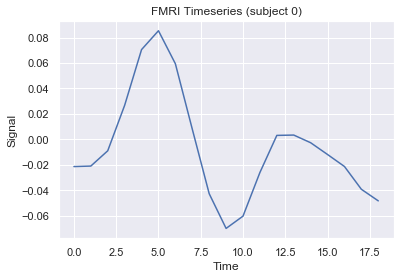

In [14]:
sns.lineplot(x = "timepoint", y="signal", data=s0, estimator=None)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("FMRI Timeseries (subject 0)")

In [15]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation

Text(0.5,1,'FMRI Timeseries (subject 0)')

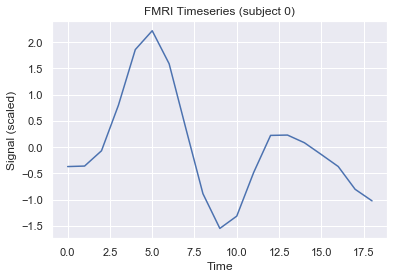

In [16]:
import numpy as np
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
s0['signal_scaled'] = scaler.fit_transform(s0['signal'].tolist())[0].ravel()
sns.lineplot(x = "timepoint", y="signal_scaled", data=s0, estimator=None)
plt.xlabel("Time")
plt.ylabel("Signal (scaled)")
plt.title("FMRI Timeseries (subject 0)")

In [17]:
n_paa_segments = 4
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
s0["paa_dataset_inv"] = paa.inverse_transform(paa.fit_transform(s0['signal_scaled'].tolist()))[0].ravel()

n_sax_symbols = 4
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(s0['signal_scaled'].tolist()))

sax_dataset_inv[0].ravel()

array([ 0.31863936,  0.31863936,  0.31863936,  0.31863936,  1.15034938,
        1.15034938,  1.15034938,  1.15034938, -1.15034938, -1.15034938,
       -1.15034938, -1.15034938,  0.31863936,  0.31863936,  0.31863936,
        0.31863936,  0.        ,  0.        ,  0.        ])

In [18]:
vocabulary = ['A', 'B', 'C', 'D']

def map_SAX_vocabulary(sax, vocabulary):
    unique_values = list(set(sax[0].ravel()))
    print("Unique values:", unique_values)
    result = []
    for i, j in enumerate(sax[0].ravel()):
        print("Evaluating timeseries item #{}: {}".format(i, j))
        x, = np.where(unique_values==j)
        print("\tFetching SAX value #{}: {}".format(x[0], vocabulary[x[0]]))
        result.append(vocabulary[x[0]])
    return result
    
SAX = map_SAX_vocabulary(sax_dataset_inv, vocabulary)

Unique values: [0.31863936396437514, 1.1503493803760079, 0.0, -1.1503493803760079]
Evaluating timeseries item #0: 0.31863936396437514
	Fetching SAX value #0: A
Evaluating timeseries item #1: 0.31863936396437514
	Fetching SAX value #0: A
Evaluating timeseries item #2: 0.31863936396437514
	Fetching SAX value #0: A
Evaluating timeseries item #3: 0.31863936396437514
	Fetching SAX value #0: A
Evaluating timeseries item #4: 1.1503493803760079
	Fetching SAX value #1: B
Evaluating timeseries item #5: 1.1503493803760079
	Fetching SAX value #1: B
Evaluating timeseries item #6: 1.1503493803760079
	Fetching SAX value #1: B
Evaluating timeseries item #7: 1.1503493803760079
	Fetching SAX value #1: B
Evaluating timeseries item #8: -1.1503493803760079
	Fetching SAX value #3: D
Evaluating timeseries item #9: -1.1503493803760079
	Fetching SAX value #3: D
Evaluating timeseries item #10: -1.1503493803760079
	Fetching SAX value #3: D
Evaluating timeseries item #11: -1.1503493803760079
	Fetching SAX value #

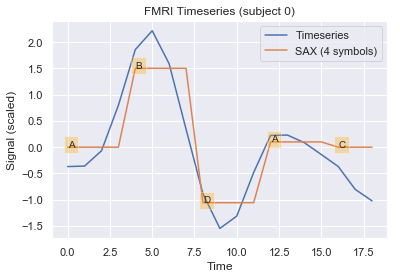

In [19]:
sns.lineplot(x = "timepoint", y="signal_scaled", data=s0, estimator=None, label="Timeseries")
sns.lineplot(x = "timepoint", y="paa_dataset_inv", data=s0, estimator=None, label="SAX (4 symbols)")
plt.xlabel("Time")
plt.ylabel("Signal (scaled)")
plt.title("FMRI Timeseries (subject 0)")
plt.legend()

# Annotate SAX word
for i, w in enumerate(SAX):
    if i == 0:
        plt.text(i, s0.loc[i]["paa_dataset_inv"], SAX[i], bbox=dict(facecolor='orange', alpha=0.3))
        current_letter = SAX[i]
    else:
        if w != current_letter:
            plt.text(i, s0.loc[i]["paa_dataset_inv"], SAX[i], bbox=dict(facecolor='orange', alpha=0.3))
            current_letter = SAX[i]